In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import torch
from loader import *
import matplotlib.pyplot as plt
import h5py
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
import matplotlib.transforms as mtransforms
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.ticker import MaxNLocator
from utils import *
from PCAfold import normalized_variance_derivative, cost_function_normalized_variance_derivative
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

logging.disable(logging.CRITICAL)

# Supplemnetary material: Heuristic vs. optimized PV for what the PV source term concerns in the logarithmic scale

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"

#create all the datasets
mixture_fractions_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

In [4]:
filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_24Mar2025-hour_10h50_Tr0D-2s_s2"

filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = False
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_min_train = PV_optimized_train.min()
PV_optimized_max_train = PV_optimized_train.max()
PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)
f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()

(241519, 21)


### Heuristic PV

In [5]:
PV_Xu_train = state_space_train["H2O"] - state_space_train["H2"] - state_space_train["O2"]
PV_Xu_train = PV_Xu_train.to_numpy().reshape(-1,1)

PV_Xu_train_source = state_space_source_train["H2O"] - state_space_source_train["H2"] - state_space_source_train["O2"]
PV_Xu_train_source = PV_Xu_train_source.to_numpy().reshape(-1,1)

Output_species = ['H2O2', 'H2O', 'H2', 'HO2', 'N2O', 'NO2', 'NO', 'O2', 'OH']

output_matrix = state_space_train[Output_species].to_numpy()

## Visualize PV source term

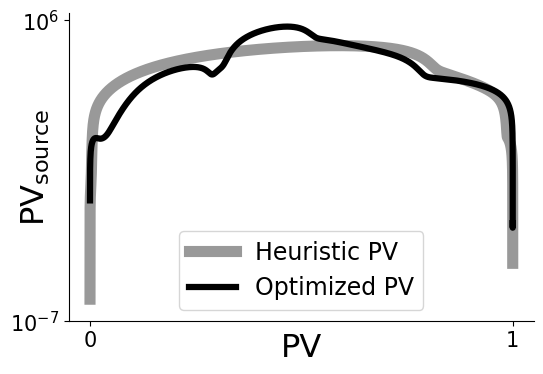

In [12]:
save = True
pathSave = "C:/Users/Admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/Heuristic-vs-optimized/"
nameSave = "Suppl-mat-PV-source-term-traj4-log-scale-HeuristicVsOptimizedPV.png"

# -----------------------------
# Create figure for single panel
# -----------------------------
fig, ax01 = plt.subplots(figsize=(6, 4))  # adjust size as needed

# -----------------------------
# Load test trajectories
# -----------------------------
idxTraj = 4

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{idxTraj}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = model.get_PV(torch.from_numpy(
        np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

# Normalize if needed
PV_optimized_test = (PV_optimized_test - PV_optimized_test.min()) / (PV_optimized_test.max() - PV_optimized_test.min())
PV_Xu_test = (PV_Xu_test - PV_Xu_test.min()) / (PV_Xu_test.max() - PV_Xu_test.min())

# -----------------------------
# Plot trajectories
# -----------------------------
first_negative_idx = np.where(PV_Xu_source_test < 0)[0][0]
ax01.plot(PV_Xu_test[:first_negative_idx], PV_Xu_source_test[:first_negative_idx],
          linewidth=8, color=str(0.6), label="Heuristic PV")

first_negative_idx = np.where(PV_optimized_source_test < 0)[0][0]
ax01.plot(PV_optimized_test[:first_negative_idx], PV_optimized_source_test[:first_negative_idx],
          linewidth=4.5, color="k", linestyle="-", label="Optimized PV")

# -----------------------------
# Labels, legend, axes formatting
# -----------------------------
ax01.set_xlabel("PV", fontsize=23, labelpad=-13)
ax01.set_ylabel("PV$_{\mathrm{source}}$", fontsize=23, labelpad=-30)
ax01.set_xticks([0, 1])
ax01.tick_params(axis='x', labelsize=15)
ax01.tick_params(axis='y', labelsize=15)
ax01.set_ylim([1e-7, 2e6])
ax01.set_yscale("log")
ax01.set_yticks([1e-7, 1e6])
ax01.legend(fontsize=17, ncol=1, loc='lower center')

# Remove top and right spines
ax01.spines['top'].set_visible(False)
ax01.spines['right'].set_visible(False)

# -----------------------------
# Save figure
# -----------------------------
if save:
    plt.savefig(pathSave + nameSave, dpi=1000, bbox_inches='tight')

plt.show()
